9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.6175 - loss: 0.6744 - val_accuracy: 0.4900 - val_loss: 4.1262
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.8457 - loss: 0.3352 - val_accuracy: 0.5200 - val_loss: 2.2504
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.9771 - loss: 0.0956 - val_accuracy: 0.5200 - val_loss: 2.9285
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.9767 - loss: 0.0803 - val_accuracy: 0.4900 - val_loss: 4.2012
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.9644 - loss: 0.0968 - val_accuracy: 0.5200 - val_loss: 1.9020
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 0.9690 - loss: 0.0665 - val_accuracy: 0.7000 - val_loss: 0.6341
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.9976 - loss: 0.0175 - val_accuracy: 0.5400 - val_loss: 0.7820
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 1.0000 - loss

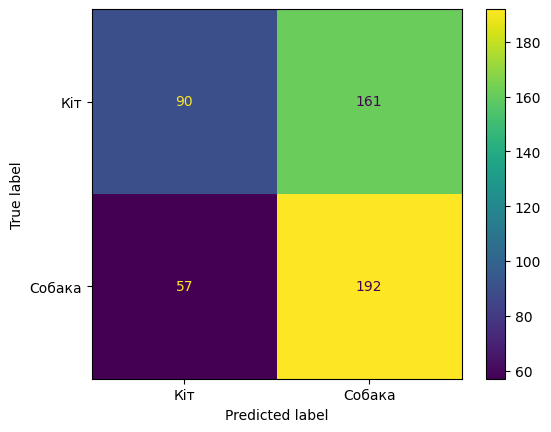

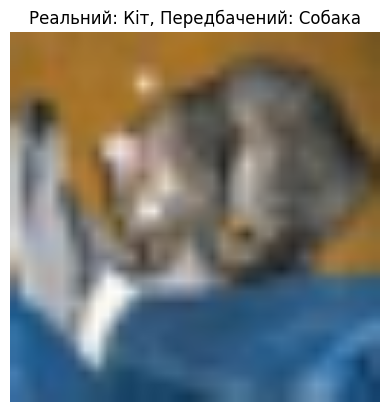

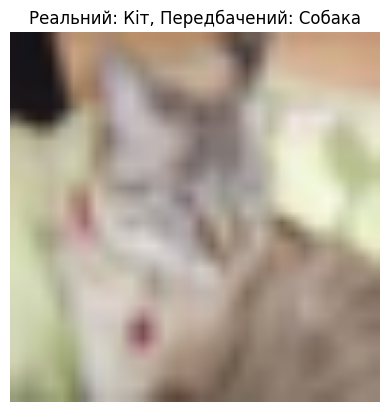

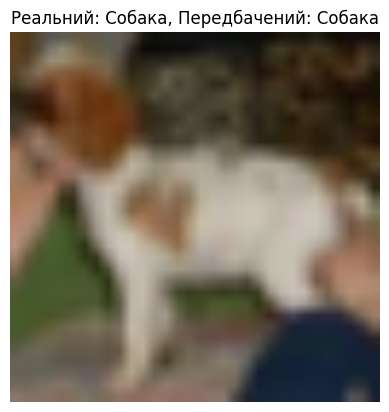

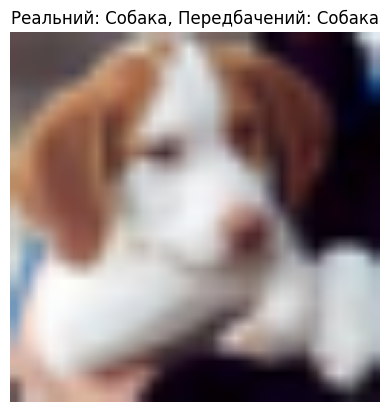

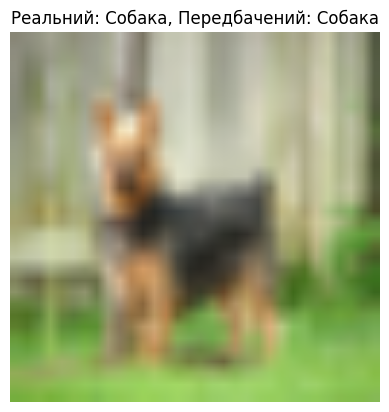

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Завантаження CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Вибір двох класів (наприклад, 3 - Кіт, 5 - Собака)
class_1, class_2 = 3, 5
train_mask = np.isin(y_train, [class_1, class_2]).flatten()
test_mask = np.isin(y_test, [class_1, class_2]).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# Обмеження кількості даних до 500 зображень
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]

# Перекодування міток на 0 та 1
y_train = (y_train == class_2).astype(np.int32).flatten()
y_test = (y_test == class_2).astype(np.int32).flatten()

# 2. Масштабування зображень
IMG_SIZE = 224
x_train = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)) / 255.0
x_test = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)) / 255.0

# 3. Завантаження моделі MobileNetV2 без TensorFlow Hub
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,  # Без верхнього шару
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg',  # Середнє зважене обчислення для кожного каналу
    weights='imagenet'  # Попередньо навчена модель
)

# 4. Адаптація моделі за допомогою Functional API
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))  # Вхідний шар
x = base_model(inputs, training=False)  # Проходимо через базову модель, без тренування
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Додаємо шар для класифікації
model = tf.keras.Model(inputs=inputs, outputs=x)  # Створюємо модель

# 5. Компіляція та тренування моделі
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=5)

# 6. Fine-tuning (розморожуємо частину шарів)
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(x_train, y_train, validation_split=0.2, epochs=5)

# 7. Оцінка моделі
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Точність моделі: {accuracy:.2f}")

# Матриця похибок
y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Кіт", "Собака"])
disp.plot()
plt.show()

# 8. Візуалізація результатів
for i in range(5):
    plt.imshow(x_test[i])
    plt.title(f"Реальний: {'Собака' if y_test[i] else 'Кіт'}, Передбачений: {'Собака' if y_pred[i] else 'Кіт'}")
    plt.axis('off')
    plt.show()
